In [ ]:
!pip install -q py3Dmol


In [ ]:
!pip install -q ase openpyxl tqdm


In [ ]:
# ----------------------------------------
# 📌 ONE-TIME USER INPUT BLOCK
# ----------------------------------------
user_input = {
    'element_A': 'Pt',
    'element_B': 'Ru',
    'composition_A': 0.5,
    'temperature': 250.0,
    'n_steps': 10000,
    'save_interval': 1000,
    'capture_frames': True,
    'frame_interval': 1000,
    'layers': (7, 7, 7),
    'surfaces': [(1, 1, 1), (1, 1, 1), (1, 1, 0)],
    'lattice_type': 'fcc',  # Choose 'fcc', 'bcc', or 'hcp'
    'coefficients': {
        'xA-A': -0.022078,
        'xB-B': -0.150000,
        'xA-B': -0.109575,
        'xA-S': -0.250717,
        'xB-S': -0.300000,
        'xA-A-out': 0.184150,
        'xB-B-out': 0.332228,
        'xA-B-out': 0.051042
    }
}



In [ ]:
import random, math, time, os
import numpy as np
from ase.io import write, read
from ase.neighborlist import build_neighbor_list
from openpyxl import Workbook
from tqdm import tqdm

# ASE cluster imports for lattices
from ase.cluster import FaceCenteredCubic, BodyCenteredCubic, HexagonalClosedPacked

# --- Extract user inputs ---
A = user_input['element_A']
B = user_input['element_B']
composition_A = user_input['composition_A']
T = user_input['temperature']
N_STEPS = user_input['n_steps']
SAVE_INTERVAL = user_input['save_interval']
LAYERS = user_input['layers']
SURFACES = user_input['surfaces']
COEFFS = user_input['coefficients']
LATTICE_TYPE = user_input.get('lattice_type', 'fcc').lower()  # default fcc
BOLTZMANN_K = 8.617333262e-5
BULK_COORD = 12

# --- Map lattice type to ASE cluster builder ---
lattice_map = {
    'fcc': FaceCenteredCubic,
    'bcc': BodyCenteredCubic,
    'hcp': HexagonalClosedPacked
}

ClusterBuilder = lattice_map.get(LATTICE_TYPE)
if ClusterBuilder is None:
    raise ValueError(f"Unsupported lattice type '{LATTICE_TYPE}'. Choose from 'fcc', 'bcc', or 'hcp'.")

# --- Generate Nanoparticle ---
particle = ClusterBuilder(A, surfaces=SURFACES, layers=LAYERS)
n_atoms = len(particle)
n_A = int(n_atoms * composition_A)
indices_A = random.sample(range(n_atoms), n_A)
for i in range(n_atoms):
    particle[i].symbol = A if i in indices_A else B

xyz_file = f"{A}{B}_initial_{n_atoms}.xyz"
write(xyz_file, particle)
print(f"✅ Structure generated with {n_atoms} atoms in {LATTICE_TYPE.upper()} lattice. Saved as: {xyz_file}")

# --- Helper Functions ---
def symbol_type(sym):
    return 'A' if sym == A else 'B'

def calculate_energy(p, coeffs):
    nl = build_neighbor_list(p, bothways=True, self_interaction=False)
    count = {k: 0 for k in coeffs}
    for i in range(len(p)):
        t_i = symbol_type(p[i].symbol)
        neighbors = nl.get_neighbors(i)[0]
        if len(neighbors) < BULK_COORD:
            count[f'x{t_i}-S'] += 1
        for j in neighbors:
            if i < j:
                t_j = symbol_type(p[j].symbol)
                if t_i == t_j:
                    count[f'x{t_i}-{t_j}'] += 1
                else:
                    count['xA-B'] += 1
    return sum(coeffs[k] * count[k] for k in count)

def count_surface(p):
    nl = build_neighbor_list(p, bothways=True, self_interaction=False)
    total_A, surf, surf_A = 0, 0, 0
    for i in range(len(p)):
        neighbors = nl.get_neighbors(i)[0]
        t = symbol_type(p[i].symbol)
        if t == 'A': total_A += 1
        if len(neighbors) < BULK_COORD:
            surf += 1
            if t == 'A': surf_A += 1
    ratio = surf_A / surf if surf else 0
    return total_A, surf, surf_A, ratio


✅ Structure generated with 423 atoms in FCC lattice. Saved as: PtRu_initial_423.xyz


In [ ]:
# Save initial state for comparison
initial_surface_data = count_surface(particle)
initial_xyz = f"{A}{B}_initial_{n_atoms}.xyz"
write(initial_xyz, particle)
print(f"🧬 Initial structure saved for reference: {initial_xyz}")


🧬 Initial structure saved for reference: PtRu_initial_423.xyz


In [ ]:
from ase.io import write
import os

# --- Parameters ---
SAVE_INTERVAL = 200               # Interval for logging data
SNAPSHOT_INTERVAL = 500         # Interval for saving .xyz snapshots
os.makedirs("trajectory", exist_ok=True)

# --- Monte Carlo Simulation ---
energy = calculate_energy(particle, COEFFS)
log = []
start_time = time.time()
print("\n🔁 Starting Monte Carlo Simulation...\n")

for step in tqdm(range(1, N_STEPS + 1)):
    i = random.randint(0, n_atoms - 1)
    neighbors = build_neighbor_list(particle).get_neighbors(i)[0]
    if len(neighbors) == 0: continue
    j = random.choice(neighbors)
    if particle[i].symbol == particle[j].symbol: continue

    trial = particle.copy()
    trial[i].symbol, trial[j].symbol = trial[j].symbol, trial[i].symbol
    dE = calculate_energy(trial, COEFFS) - energy

    if dE < 0 or random.random() < math.exp(-dE / (BOLTZMANN_K * T)):
        particle = trial
        energy += dE

    # 🧾 Log data
    if step % SAVE_INTERVAL == 0:
        total_A, surf, surf_A, ratio = count_surface(particle)
        log.append({
            'Step': step,
            'Energy (eV)': energy,
            f'Total {A}': total_A,
            'Surface Atoms': surf,
            f'{A} on Surface': surf_A,
            f'Surface {A} Ratio': ratio
        })
        print(f"📘 Step {step} | Energy: {energy:.3f} eV | Surface {A} Ratio: {ratio:.4f}")

    # 📸 Save snapshot
    if step % SNAPSHOT_INTERVAL == 0:
        snapshot_file = f"trajectory/step_{step:05d}.xyz"
        write(snapshot_file, particle)
        print(f"📸 Saved snapshot at step {step}")



🔁 Starting Monte Carlo Simulation...



  4%|▍         | 403/10000 [00:12<07:30, 21.31it/s]

📘 Step 400 | Energy: -276.645 eV | Surface Pt Ratio: 0.4961


  8%|▊         | 804/10000 [00:24<04:55, 31.10it/s]

📘 Step 800 | Energy: -280.942 eV | Surface Pt Ratio: 0.5155


 12%|█▏        | 1205/10000 [00:37<04:53, 29.98it/s]

📘 Step 1200 | Energy: -283.666 eV | Surface Pt Ratio: 0.5310


 14%|█▍        | 1403/10000 [00:43<04:34, 31.31it/s]

📘 Step 1400 | Energy: -285.630 eV | Surface Pt Ratio: 0.5349


 18%|█▊        | 1808/10000 [00:56<04:26, 30.76it/s]

📘 Step 1800 | Energy: -288.859 eV | Surface Pt Ratio: 0.5543


 20%|██        | 2004/10000 [01:03<06:21, 20.95it/s]

📘 Step 2000 | Energy: -289.221 eV | Surface Pt Ratio: 0.5426
📸 Saved snapshot at step 2000


 22%|██▏       | 2202/10000 [01:10<05:16, 24.63it/s]

📘 Step 2200 | Energy: -289.747 eV | Surface Pt Ratio: 0.5543


 24%|██▍       | 2403/10000 [01:17<05:47, 21.86it/s]

📘 Step 2400 | Energy: -290.630 eV | Surface Pt Ratio: 0.5775


 26%|██▌       | 2606/10000 [01:22<03:46, 32.71it/s]

📘 Step 2600 | Energy: -291.067 eV | Surface Pt Ratio: 0.5775


 28%|██▊       | 2806/10000 [01:29<04:46, 25.09it/s]

📘 Step 2800 | Energy: -291.639 eV | Surface Pt Ratio: 0.5775


 30%|███       | 3004/10000 [01:35<03:55, 29.69it/s]

📘 Step 3000 | Energy: -292.081 eV | Surface Pt Ratio: 0.5698
📸 Saved snapshot at step 3000


 36%|███▌      | 3606/10000 [01:55<04:36, 23.15it/s]

📘 Step 3600 | Energy: -292.608 eV | Surface Pt Ratio: 0.5659


 44%|████▍     | 4403/10000 [02:20<06:59, 13.33it/s]

📘 Step 4400 | Energy: -293.291 eV | Surface Pt Ratio: 0.5736


 46%|████▌     | 4604/10000 [02:27<03:04, 29.22it/s]

📘 Step 4600 | Energy: -293.627 eV | Surface Pt Ratio: 0.5620


 48%|████▊     | 4806/10000 [02:34<03:22, 25.61it/s]

📘 Step 4800 | Energy: -293.822 eV | Surface Pt Ratio: 0.5620


 54%|█████▍    | 5400/10000 [02:52<01:58, 38.90it/s]

📘 Step 5400 | Energy: -294.532 eV | Surface Pt Ratio: 0.5698


 55%|█████▌    | 5504/10000 [02:55<02:30, 29.78it/s]

📸 Saved snapshot at step 5500


 58%|█████▊    | 5805/10000 [03:05<02:16, 30.76it/s]

📘 Step 5800 | Energy: -294.585 eV | Surface Pt Ratio: 0.5698


 65%|██████▌   | 6504/10000 [03:28<01:52, 30.98it/s]

📸 Saved snapshot at step 6500


 66%|██████▌   | 6605/10000 [03:31<01:41, 33.57it/s]

📘 Step 6600 | Energy: -294.687 eV | Surface Pt Ratio: 0.5814


 72%|███████▏  | 7204/10000 [03:51<01:42, 27.31it/s]

📘 Step 7200 | Energy: -294.761 eV | Surface Pt Ratio: 0.5814


 74%|███████▍  | 7404/10000 [03:57<01:09, 37.42it/s]

📘 Step 7400 | Energy: -294.869 eV | Surface Pt Ratio: 0.5814


 75%|███████▌  | 7501/10000 [04:00<01:34, 26.54it/s]

📸 Saved snapshot at step 7500


 80%|████████  | 8004/10000 [04:17<01:18, 25.51it/s]

📘 Step 8000 | Energy: -294.822 eV | Surface Pt Ratio: 0.5814
📸 Saved snapshot at step 8000


 84%|████████▍ | 8405/10000 [04:30<00:49, 32.16it/s]

📘 Step 8400 | Energy: -294.878 eV | Surface Pt Ratio: 0.5775


 85%|████████▌ | 8505/10000 [04:33<00:50, 29.68it/s]

📸 Saved snapshot at step 8500


 86%|████████▌ | 8606/10000 [04:36<00:34, 41.00it/s]

📘 Step 8600 | Energy: -294.925 eV | Surface Pt Ratio: 0.5775


 88%|████████▊ | 8805/10000 [04:43<00:34, 35.00it/s]

📘 Step 8800 | Energy: -295.084 eV | Surface Pt Ratio: 0.5814


 90%|█████████ | 9002/10000 [04:49<00:31, 31.75it/s]

📘 Step 9000 | Energy: -295.209 eV | Surface Pt Ratio: 0.5736
📸 Saved snapshot at step 9000


 92%|█████████▏| 9206/10000 [04:56<00:24, 32.83it/s]

📘 Step 9200 | Energy: -295.241 eV | Surface Pt Ratio: 0.5775


 95%|█████████▌| 9502/10000 [05:05<00:21, 23.70it/s]

📸 Saved snapshot at step 9500


100%|██████████| 10000/10000 [05:21<00:00, 31.09it/s]


In [ ]:
!pip install ase imageio


In [ ]:
# --- Save Final Structure and Excel Log ---
final_xyz = f"final_{A}{B}_{n_atoms}.xyz"
write(final_xyz, particle)
print(f"\n✅ Final structure saved as: {final_xyz}")
print(f"⏱️ Total simulation time: {time.time() - start_time:.2f} seconds")

# Excel log export
xlsx_file = f"MMC_{A}{B}_log.xlsx"
wb = Workbook()
ws = wb.active
ws.title = "Simulation Log"

params = [
    ("Element A", A), ("Element B", B), ("Composition A", composition_A),
    ("Temperature (K)", T), ("MC Steps", N_STEPS),
    ("Save Interval", SAVE_INTERVAL), ("Total Atoms", n_atoms)
]
for i, (k, v) in enumerate(params, 1):
    ws.cell(row=i, column=1, value=k)
    ws.cell(row=i, column=2, value=v)

header_row = len(params) + 2
headers = list(log[0].keys())
for j, h in enumerate(headers, 1):
    ws.cell(row=header_row, column=j, value=h)

for i, entry in enumerate(log, header_row + 1):
    for j, h in enumerate(headers, 1):
        ws.cell(row=i, column=j, value=entry[h])

wb.save(xlsx_file)
print(f"📁 Log file saved: {xlsx_file}")



✅ Final structure saved as: final_PtRu_423.xyz
⏱️ Total simulation time: 4054.04 seconds
📁 Log file saved: MMC_PtRu_log.xlsx


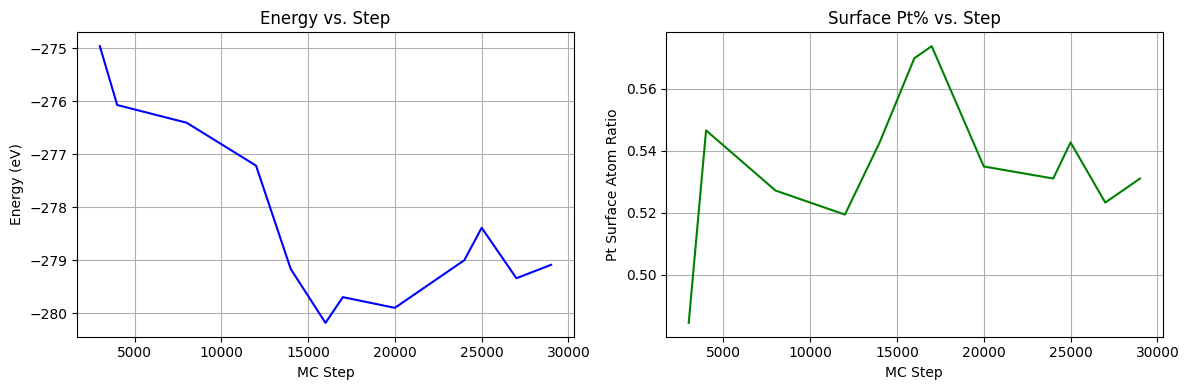

In [ ]:
import matplotlib.pyplot as plt

steps = [entry['Step'] for entry in log]
energy = [entry['Energy (eV)'] for entry in log]
surface_ratio = [entry[f'Surface {A} Ratio'] for entry in log]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(steps, energy, label='Energy (eV)', color='blue')
plt.xlabel('MC Step'); plt.ylabel('Energy (eV)')
plt.title('Energy vs. Step'); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(steps, surface_ratio, label=f'Surface {A} Ratio', color='green')
plt.xlabel('MC Step'); plt.ylabel(f'{A} Surface Atom Ratio')
plt.title(f'Surface {A}% vs. Step'); plt.grid(True)

plt.tight_layout(); plt.show()


In [ ]:
# --- ✅ Final Validation & Sanity Check ---

import math
import numpy as np

print("\n🔍 Running validation checks...")
errors = 0

# 1. Atom count check
if len(particle) != n_atoms:
    print(f"❌ Atom count mismatch: expected {n_atoms}, found {len(particle)}")
    errors += 1
else:
    print(f"✅ Atom count is correct: {n_atoms}")

# 2. Final energy NaN check (use the last logged energy)
final_energy = log[-1]['Energy (eV)']
if isinstance(final_energy, (float, int)):
    if math.isnan(final_energy):
        print("❌ Final energy is NaN.")
        errors += 1
    else:
        print(f"✅ Final energy is valid: {final_energy:.4f} eV")
else:
    print("❌ Final energy is not a scalar.")
    errors += 1

# 3. Surface atom sanity
_, surf_atoms, surf_A, final_ratio = count_surface(particle)
if surf_atoms == 0:
    print("❌ No surface atoms detected.")
    errors += 1
else:
    print(f"✅ Surface atoms present: {surf_atoms} total, {surf_A} are {A} atoms.")
    print(f"➡️ Final Surface {A}%: {final_ratio:.4f}")

# 4. Surface ratio non-trivial
if final_ratio == 0 or final_ratio == 1:
    print("⚠️ Surface composition is fully segregated. May or may not be physical.")
else:
    print("✅ Surface composition is mixed.")

# Final validation result
if errors == 0:
    print("\n✅ Validation PASSED. System is physically consistent.")
else:
    print(f"\n⚠️ Validation completed with {errors} issue(s). Check configuration.")



🔍 Running validation checks...
✅ Atom count is correct: 423
✅ Final energy is valid: -279.0900 eV
✅ Surface atoms present: 258 total, 138 are Pt atoms.
➡️ Final Surface Pt%: 0.5349
✅ Surface composition is mixed.

✅ Validation PASSED. System is physically consistent.


In [ ]:
# --- 📊 Compare Before vs After Surface Ratios ---
init_total, init_surf, init_surf_A, init_ratio = initial_surface_data
final_total, final_surf, final_surf_A, final_ratio = count_surface(particle)

print("\n🔁 Surface Comparison: BEFORE vs AFTER")
print(f"  Surface atoms:         {init_surf:>4} ➡️ {final_surf:>4}")
print(f"  {A} on surface:        {init_surf_A:>4} ➡️ {final_surf_A:>4}")
print(f"  Surface {A} Ratio:   {init_ratio:.4f} ➡️ {final_ratio:.4f}")

delta = final_ratio - init_ratio
change_str = f"🔼 Increased by {delta:.4f}" if delta > 0 else f"🔽 Decreased by {abs(delta):.4f}" if delta < 0 else "No change"
print(f"  ➡️ Change: {change_str}")



🔁 Surface Comparison: BEFORE vs AFTER
  Surface atoms:          258 ➡️  258
  Pt on surface:         123 ➡️  138
  Surface Pt Ratio:   0.4767 ➡️ 0.5349
  ➡️ Change: 🔼 Increased by 0.0581


In [ ]:
!pip install -q py3Dmol


In [ ]:
def view_xyz_colored(xyz_file, atom_A, atom_B, radius=1.5):
    import py3Dmol
    from IPython.display import display

    with open(xyz_file) as f:
        xyz_data = f.read()

    view = py3Dmol.view(width=500, height=500)
    view.addModel(xyz_data, 'xyz')

    # Style atoms by element symbol from parameters
    view.setStyle(
        { "elem": atom_A },
        { "sphere": { "color": "gold", "radius": radius } }
    )
    view.setStyle(
        { "elem": atom_B },
        { "sphere": { "color": "green", "radius": radius } }
    )

    view.setBackgroundColor("white")
    view.zoomTo()
    return view


In [ ]:
print("🧬 Initial Structure")
view_xyz_colored(initial_xyz, atom_A=A, atom_B=B).show()

print("🧬 Final Structure")
view_xyz_colored(final_xyz, atom_A=A, atom_B=B).show()


🧬 Initial Structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

🧬 Final Structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import os
import imageio.v2 as imageio  # use v2 to suppress future deprecation warnings
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize.plot import plot_atoms
from ase.data.colors import jmol_colors
import openpyxl

# --- User Parameters ---
trajectory_folder = "trajectory"  # Folder containing your .xyz snapshots
xlsx_file = "MMC_PtRu_log.xlsx"   # Your MMC simulation Excel log filename
fps = 1                          # Video frames per second
output_movie = "3D_MC_Enhanced_Movie_With_Inset.mp4"

# Custom color map for atoms
symbol_to_color = {
    'Pt': 'silver',
    'Ru': 'royalblue',
    'Fe': '#d62728',
    'Sn': '#2ca02c',
    'Pb': '#ff7f0e',
    'Co': '#9467bd',
    'Au': '#e6c200',
    'Cu': '#17becf',
}

# --- Load MMC Excel Log ---
print(f"📥 Loading Excel log: {xlsx_file}")
wb = openpyxl.load_workbook(xlsx_file, data_only=True)
ws = wb.active  # Adjust if your log is on a different sheet by name

# Find header row (skip param rows) - here assumed after 8 rows of params + 1 blank line
header_row = 10  # Change this if your excel layout differs
headers = [cell.value for cell in ws[header_row]]

# Find required columns
step_col = headers.index('Step') + 1
energy_col = headers.index('Energy (eV)') + 1
surface_ratio_col = None
for key in ['Surface Ratio', 'Surface Atoms Ratio', 'Surface A Ratio', 'Surface Ratio (A)']:
    if key in headers:
        surface_ratio_col = headers.index(key) + 1
        break

steps = []
energies = []
surface_ratios = []

for row in ws.iter_rows(min_row=header_row+1, max_row=ws.max_row):
    steps.append(row[step_col-1].value)
    energies.append(row[energy_col-1].value)
    if surface_ratio_col:
        surface_ratios.append(row[surface_ratio_col-1].value)
    else:
        surface_ratios.append(None)

print(f"Loaded {len(steps)} log entries from Excel.")

# --- Load XYZ Snapshots ---
xyz_files = sorted([f for f in os.listdir(trajectory_folder) if f.endswith(".xyz")])
print(f"📦 Found {len(xyz_files)} snapshots in '{trajectory_folder}'.")

images = []

for step_idx, xyz_file in enumerate(xyz_files, 1):
    atoms = read(os.path.join(trajectory_folder, xyz_file))
    label = xyz_file.replace(".xyz", "")  # e.g. 'step_01500'

    # Parse numeric step number from filename (assumes format like step_01500)
    try:
        current_step = int(''.join(filter(str.isdigit, label)))
    except:
        current_step = step_idx  # fallback if parsing fails

    # Assign atom colors and count present elements
    colors = {}
    element_counts = {}
    for i, atom in enumerate(atoms):
        symbol = atom.symbol
        colors[i] = symbol_to_color.get(symbol, tuple(jmol_colors[atom.number]))
        element_counts[symbol] = element_counts.get(symbol, 0) + 1

    print(f"🎬 Rendering {label} (Step {current_step})...")

    # Setup plot
    fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
    fig.patch.set_facecolor('#f0f0f0')
    ax.set_facecolor('#f0f0f0')

    plot_atoms(
        atoms, ax,
        radii=0.6,
        colors=colors,
        rotation=('30x,30y,0z'),
        show_unit_cell=0
    )

    # Frame label bottom-right
    fig.text(
        0.95, 0.05, label,
        ha='right', va='bottom',
        fontsize=11, color='black',
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
    )

    # Legend top-left with counts, e.g. ● Pt (58)
    x0, y0 = 0.05, 0.95
    dy = 0.035
    for idx, symbol in enumerate(sorted(element_counts.keys())):
        count = element_counts[symbol]
        fig.text(
            x0, y0 - idx * dy,
            f"● {symbol} ({count})",
            fontsize=10,
            ha='left', va='top',
            color=symbol_to_color.get(symbol, 'gray'),
            fontweight='bold'
        )

    # Inset plot: energy and surface ratio up to current step
    inset_ax = fig.add_axes([0.6, 0.75, 0.35, 0.2])  # x, y, width, height (figure coords)
    # Find closest log index for current_step
    idx = min(range(len(steps)), key=lambda i: abs(steps[i] - current_step))

    inset_ax.plot(steps[:idx + 1], energies[:idx + 1], color='blue', label='Energy (eV)')
    if surface_ratio_col:
        inset_ax.plot(steps[:idx + 1], surface_ratios[:idx + 1], color='orange', label='Surface Ratio')

    inset_ax.set_xlabel('Step', fontsize=8)
    inset_ax.set_ylabel('Value', fontsize=8)
    inset_ax.tick_params(axis='both', which='major', labelsize=7)
    inset_ax.legend(fontsize=7)
    inset_ax.grid(True, linestyle='--', alpha=0.5)

    ax.axis('off')

    # Save frame image
    tmp_png = f"/tmp/{xyz_file}.png"
    fig.savefig(tmp_png)
    plt.close(fig)

    images.append(imageio.imread(tmp_png))

# --- Compile video ---
print("🎞️ Compiling final video...")
imageio.mimsave(output_movie, images, fps=fps)
print(f"✅ Final movie saved as: {output_movie}")


📥 Loading Excel log: MMC_PtRu_log.xlsx


ValueError: 'Step' is not in list

In [ ]:
from google.colab import files
files.download("nanoparticle_evolution.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>